In [2]:
using DrWatson

@quickactivate "Hadjivasiliou_Julia_Tutorial"

projectname()

"Hadjivasiliou_Julia_Tutorial"

In [3]:
using DifferentialEquations
using ModelingToolkit
using Symbolics
using BenchmarkTools
using Plots

First basic ODE:

$\frac{du}{dt} = f(u,p,t)$

where $f(u,p,t) = pu$, on the time interval $t\in[0,5]$ with the initial condition $u_0 = 0.5$

We will initially use The Euler method. The Euler method is an example of an explicit method. This means that the new value $u_{n+1}$ is defined in terms of things that are already known, like $u_n$.

In [4]:
function f(u,p,t)
    p*u
end

u0 = 0.5
tspan = (0.0,5.0)
p = -0.5

prob = ODEProblem(f,u0,tspan,p)
sol = solve(prob, Euler(), dt = 0.01);

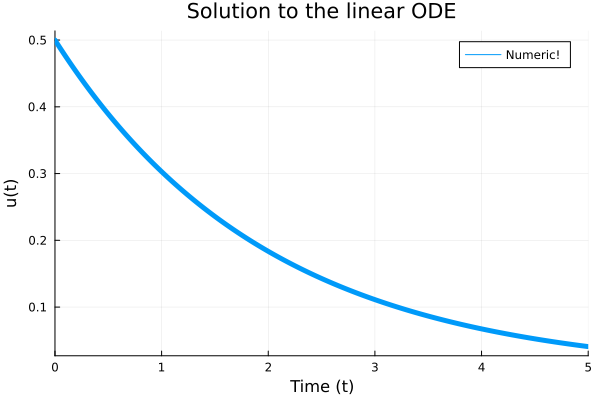

In [5]:
plot(sol,linewidth=5,title="Solution to the linear ODE",
     xaxis="Time (t)",yaxis="u(t)",label="Numeric!") # legend=false

In [6]:
sol.retcode

ReturnCode.Success = 1

In [7]:
sol.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  501
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          500
Number of rejected steps:                          0

https://en.wikipedia.org/wiki/Euler_method#Global_truncation_error

This has an analytic solution $u(t) = u_0 \exp(pt)$. We can therefore calculate the global truncation error for a range of dt. The GTE $e_n$ at time $t_n$ is defined by $e_n = u(t_n) - u_n$ where $u(t_n)$ is the true solution $u_n$ is the corresponding estimate produced by the numerical procedure: 

In [8]:
result = Dict{Float64,Float64}()

for dt in [0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
    sol = solve(prob, Euler(), dt = dt);
    GTE = maximum(map(t->u0*exp(p*t) - sol(t),sol.t))
    result[dt] = GTE
end

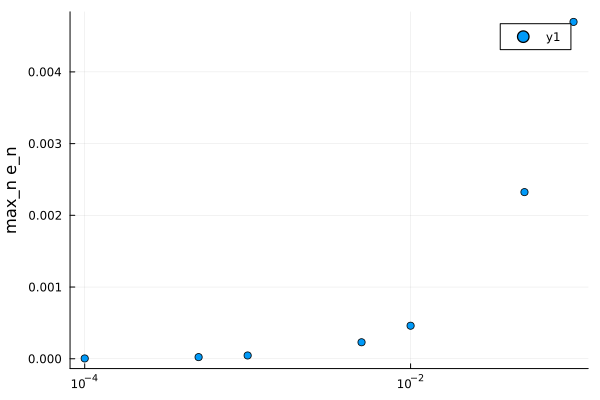

In [9]:
scatter(result,xaxis = :log,  yaxis = "max_n e_n")

Interestingly, the error varies across the solution. In some way it is dependent on the system it is solving and where you are with your current estimate. This is the idea behind adaptive methods.

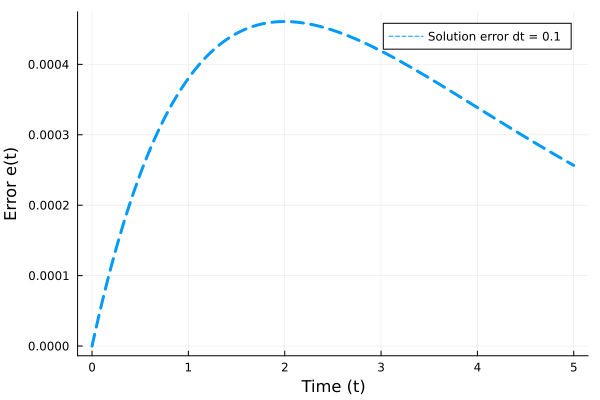

In [10]:
sol = solve(prob, Euler(), dt = 0.01);

plot(sol.t, t->abs(u0*exp(p*t) - sol(t)),lw=3,ls=:dash,label="Solution error dt = " * string(0.1),xaxis="Time (t)", yaxis = "Error e(t)")

An example of an adaptive method is Runga-Kutta Tsit5(). It varies the step size dending on its own estimate of solution error. Lets control for the same error seen by Euler. This is done using reltol and abstol. According to the DifferntialEquation documentation,a  good rule of thumb is that the total solution accuracy is 1-2 digits less than the relative tolerance reltol. Lets set reltol = 1e-6, abstol = 1e-6 and see.

In [11]:
sol = solve(prob, Tsit5(), reltol=1e-6, abstol=1e-6);

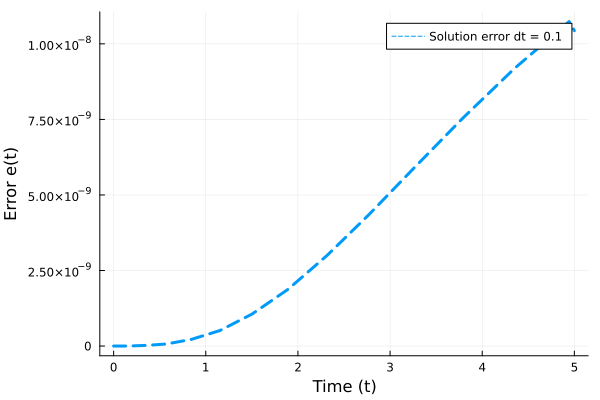

In [12]:
plot(sol.t, t->abs(u0*exp(p*t) - sol(t)),lw=3,ls=:dash,label="Solution error dt = " * string(0.1),xaxis="Time (t)", yaxis = "Error e(t)")

In [13]:
@benchmark solve(prob, Euler(), dt = 0.01, save_everystep = false)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  39.916 μs … 154.791 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     40.459 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   41.189 μs ±   3.303 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▆▆█▆▅▄▃▄▄▄▃▂▁▁▁▂▂▁▁                                          ▂
  █████████████████████▇▇▆▅▅▆▆▆▆▆▆▆▆▄▅▅▆▅▄▅▄▅▄▄▅▃▄▃▃▄▂▄▅▄▄▅▅▃▄ █
  39.9 μs       Histogram: log(frequency) by time      51.2 μs <

 Memory estimate: 1.88 KiB, allocs estimate: 22.

In [14]:
@benchmark solve(prob, Tsit5(), reltol=1e-6, abstol=1e-6,save_everystep = false)

BenchmarkTools.Trial: 10000 samples with 9 evaluations.
 Range (min … max):  2.606 μs …  1.591 ms  ┊ GC (min … max): 0.00% … 99.70%
 Time  (median):     2.806 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.011 μs ± 15.884 μs  ┊ GC (mean ± σ):  5.27% ±  1.00%

       ▂ ▄▃██▃▄ ▂▁▂                                           
  ▁▂▃▇▆████████████▇█▆▄▅▃▄▃▃▂▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  2.61 μs        Histogram: frequency by time        3.56 μs <

 Memory estimate: 3.28 KiB, allocs estimate: 22.

Next ODE: morphogen gradient - diffusion and linear degradation term

$\frac{\partial c}{\partial t} = D \frac{\partial ^ 2 c}{\partial x ^2}  - kc$

with source term $D\frac{\partial c}{\partial x}|_{x=0} = -j_0$ and zero flux at the end of the tissue, $D\frac{\partial c}{\partial x}|_{x=L} = 0$

The analytic solution $c(x) = c_0\exp(-x/\lambda) + c_1\exp(x/\lambda)$, where $\lambda = \sqrt{\frac{D}{k}}$

Lets solve this using the "method of lines". This involves transforming the PDE into a system of ODE's by discretizing in space. 

Suppose we discretize $[0,L]$ into $N$ cells, giving a step of $\Delta x = \frac{L}{N}$.
Then we let $ c_j(t) = c(x_j,t)$ where $x_j = j\Delta x$ for $j = 1,\cdots, N$. Given this definition, we can write 

$\frac{\partial}{\partial x} c(x,t) |_{x = x_j} = \frac{c_{i+1}(t) - c_{i-1}(t)}{2*\Delta x}$ and

$\frac{\partial^2}{\partial x ^ 2} c(x,t) |_{x = x_j} = \frac{\frac{c_{j+1}(t) - c_{j}(t)}{\Delta x} - \frac{c_{j}(t) - c_{j-1}(t)}{\Delta x}}{\Delta x} = \frac{c_{j+1}(t) + c_{j-1}(t) - 2*c_{j}(t)}{\Delta x ^ 2}$

Since

$\frac{\partial}{\partial t} c(x,t) |_{x = x_j} = D\frac{\partial^2}{\partial x ^ 2} c(x,t) |_{x = x_j} - kc(x,t)|_{x=x_j}$

we get the system of ODEs

$\frac{d}{dt}c_j(t) = D\frac{c_{j+1}(t) + c_{j-1}(t) - 2*c_{j}(t)}{\Delta x ^ 2} - k c_j(t)$

The Neumann boundary conditions are handled as follows:

$D\frac{\partial}{\partial x} c(x,t) |_{x = 0} = -j_0 \implies \frac{c_{1}(t) - c_{0}(t)}{2*\Delta x} = -j_0/D$ 

and

$D\frac{\partial}{\partial x} c(x,t) |_{x = L} = 0 \implies \frac{c_{N+1}(t) - c_{N}(t)}{2*\Delta x} = 0$ 

which give us correct substitions for $\frac{d}{dt}c_0(t)$ and $\frac{d}{dt}c_N(t)$

Since this gives us a system of ODEs, we can use any of the ODE timestepping methods to solve our system and hence the PDE.

In [15]:
const Nc = 1000
const L = 1.

const tissue = range(0,L,length = Nc)


function morph_grad!(du,u,p,t)

    D,k,j0,dx = p

    h = 1/dx^2

    du[1] = (2*u[2] + (2*dx*j0/D) - 2*u[1]) / dx^2 - k*u[1]

    @inbounds for j in 2:Nc-1
        du[j] =  D*h*(u[j-1] + u[j+1] - 2*u[j]) - k*u[j]
    end

    du[Nc] = (2*u[Nc-1] - 2*u[Nc]) / dx^2 - k*u[Nc]
    
end


morph_grad! (generic function with 1 method)

In [16]:
# https://sites.me.ucsb.edu/~moehlis/APC591/tutorials/tutorial5/node3.html#diffusion_eqn_fd
# https://folk.ntnu.no/leifh/teaching/tkt4140/._main056.html

In [17]:
D = 0.16
k = 1.
j0 = 0.4

p = (D,k,j0,step(tissue))

u0 = zeros(Nc)

tspan = (0,Inf)

prob = ODEProblem(morph_grad!,u0,tspan,p);

sol = solve(prob, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e6);

https://scicomp.stackexchange.com/questions/25398/understanding-the-courant-friedrichs-lewy-condition

In [18]:
sol = solve(prob, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e6);

In [19]:
λ = sqrt(D/k)
c0 = (j0*λ/D)*(1/(1-exp(-2*L/λ)))
c1 = (j0*λ/D)*(exp(-2*L/λ)/(1-exp(-2*L/λ)));

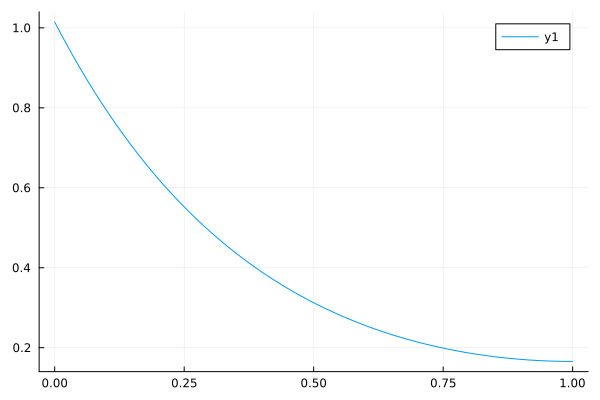

In [20]:
plot(tissue,sol.u[end])

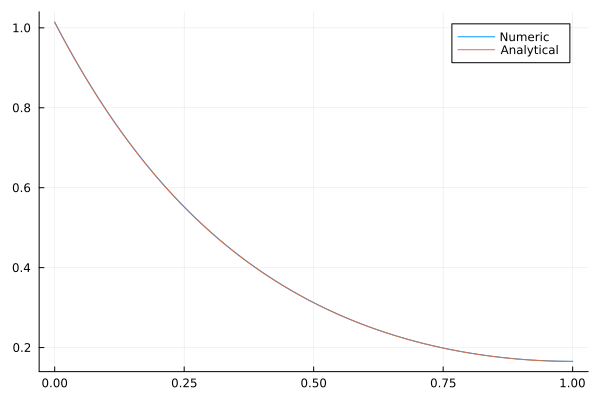

In [21]:
plot(tissue,sol.u[end],label = "Numeric")
plot!(tissue,x->c0*exp(-x/λ) + c1*exp(x/λ),label= "Analytical")

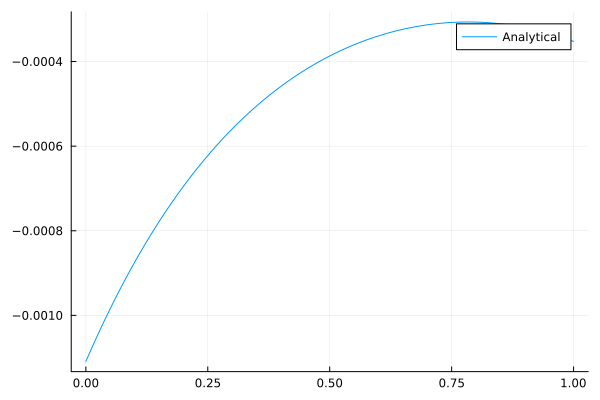

In [22]:
plot(tissue,map(x->c0*exp(-x/λ) + c1*exp(x/λ),tissue) .- sol.u[end],label= "Analytical")

In [23]:
tspan = (0,round(sol.t[end]))

prob = ODEProblem(morph_grad!,u0,tspan,p);

sol = solve(prob, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,saveat = 0:0.01:tspan[2]);

┌ Info: Saved animation to 
│   fn = /Users/boothh/Documents/Hadjivasiliou_Julia_Tutorial/plots/Animations/test.gif
└ @ Plots /Users/boothh/.julia/packages/Plots/fw4rv/src/animation.jl:156


Plots.AnimatedGif("/Users/boothh/Documents/Hadjivasiliou_Julia_Tutorial/plots/Animations/test.gif")
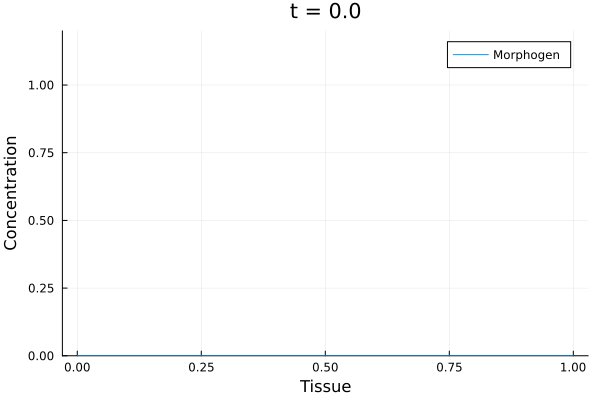

In [24]:
anim = @animate for i = 1:length(sol.u)
    plot(tissue,sol.u[i],xlabel = "Tissue",ylabel = "Concentration",title = "t = " * string(sol.t[i]),label = "Morphogen")
    plot!(ylims = (0.,1.2))
end
 
gif(anim, plotsdir("Animations","test.gif"), fps = 30)

In [25]:
tspan = (0,Inf)

prob = ODEProblem(morph_grad!,u0,tspan,p);

In [26]:
@benchmark solve(prob, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e6)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  3.438 s …   3.463 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.451 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.451 s ± 17.773 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.44 s         Histogram: frequency by time        3.46 s <

 Memory estimate: 42.31 MiB, allocs estimate: 3992.

In [27]:
using Symbolics

In [28]:
du0 = copy(u0) # what does dg look like
jac_sparsity = Symbolics.jacobian_sparsity((du,u)->morph_grad!(du,u,p,0.0),du0,u0)

1000×1000 SparseArrays.SparseMatrixCSC{Bool, Int64} with 2998 stored entries:
⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦

In [29]:
# https://github.com/SciML/DiffEqCallbacks.jl/blob/4cf478d21527327a52bf3c7916c29cd155115a51/src/terminatesteadystate.jl

In [30]:
morph_grad_sparse = ODEFunction(morph_grad!;jac_prototype=float.(jac_sparsity));

prob_sparse  = ODEProblem(morph_grad_sparse,u0,tspan,p);

In [31]:
@benchmark solve(prob_sparse, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e6)

BenchmarkTools.Trial: 22 samples with 1 evaluation.
 Range (min … max):  221.937 ms … 238.335 ms  ┊ GC (min … max): 0.00% … 7.31%
 Time  (median):     236.717 ms               ┊ GC (median):    6.99%
 Time  (mean ± σ):   235.997 ms ±   3.286 ms  ┊ GC (mean ± σ):  6.75% ± 1.52%

                                                   ▃   █▃█▃ █    
  ▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁█▇▁▇████▇█▇▇ ▁
  222 ms           Histogram: frequency by time          238 ms <

 Memory estimate: 227.04 MiB, allocs estimate: 4812271.

In [32]:
bm = @benchmark solve(prob_sparse, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e6);

In [78]:
function f(du,u,p,t)
    for i in 1:length(u)
        du[i] = p.α*u[i]
    end

end

function condition(u,t,integrator)
    return 1.0 - maximum(u) # has any cell hit 1? 
end

function affect!(integrator)
    
    u = integrator.u
    
    idx = findall(y-> y >= 1.0, u) # find all cells which have hit concentration == 1
    
    resize!(integrator,length(u)+length(idx)) # resize solution to accomodate all new divisions

    for id in reverse(idx) # for each cell hitting 1, divide:
        u[id+2:end] .= @view u[id+1:end-1]
        u[id] *= 0.5
        u[id+1] = u[id]
    end
    
    nothing
end

callback = ContinuousCallback(condition,affect!, rootfind=SciMLBase.RightRootFind)
u0 = [0.2]
tspan = (0.0,15.0)
p = (; α = 0.3)
prob = ODEProblem(f,u0,tspan, p)
sol = solve(prob,Tsit5(),callback=callback,saveat = tspan[1]:0.1:tspan[2]);

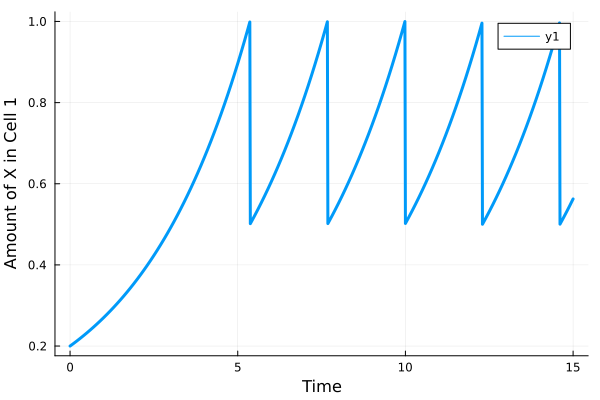

In [79]:
ts = range(0, stop=tspan[2], length=1000)
plot(ts,map((x)->x[1],sol.(ts)),lw=3, ylabel="Amount of X in Cell 1",xlabel="Time")

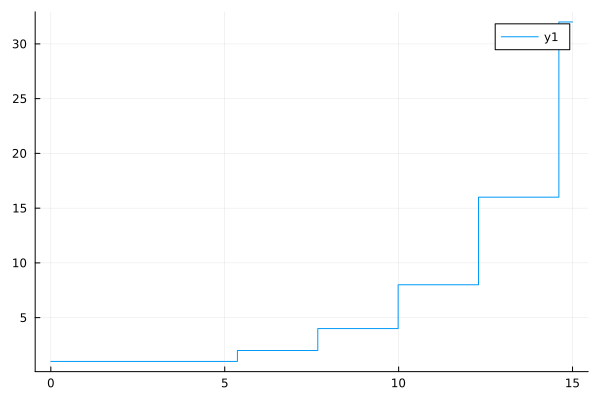

In [80]:
plot(sol.t,map(x->length(x),sol.u))

In [81]:
# https://diffeq.sciml.ai/stable/analysis/parameter_estimation/